# Risk measure estimation
**Camilo Garcia Trillos**

## In this notebook

In this notebook, we build a first complete application: estimating Value at Risk (at level 99%) and Expected Shortfall (at level 95%) for one stock (simplest case). We also look at backtesting.

In [1]:
#As usual, we start by importing the modules we require. These are:

%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy.random import normal

## Acquire and clean data

We start by reading the data from the csv table 'AIG_20171201_15y.csv'. It corresponds to [AIG](https://en.wikipedia.org/wiki/American_International_Group), an insurance company. 

Let read the data and perform some basic cleaning procedures:

- Understand what are the entries of the data
- Guarantee that the type of each entry corresponds to their meaning
- Check if there are missing data
- Choose an appropriate index
- Make a visual inspection in search of abnormal observations


We start by [reading](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) and inspecting the data

In [2]:
aig_data = pd.read_csv('~/Data/AIG_20171201_15y.csv')

In [3]:
aig_data.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,AIG,2003-01-02,58.10,60.30,57.74,60.30,6276000.0,0.0,1.0,855.602805,888.000846,850.301308,888.000846,313800.0
1,AIG,2003-01-03,60.05,60.42,59.54,60.12,3894000.0,0.0,1.0,884.319250,889.768012,876.808795,885.350097,194700.0
2,AIG,2003-01-06,60.12,62.51,60.10,62.14,5216000.0,0.0,1.0,885.350097,920.546151,885.055570,915.097389,260800.0
3,AIG,2003-01-07,62.14,62.19,60.60,60.93,5384000.0,0.0,1.0,915.097389,915.833708,892.418761,897.278467,269200.0
4,AIG,2003-01-08,60.93,61.49,59.99,60.17,3454000.0,0.0,1.0,897.278467,905.525241,883.435667,886.086416,172700.0


In [4]:
aig_data.tail()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
3751,AIG,2017-11-27,59.10,59.190,58.6900,58.76,4138130.0,0.0,1.0,59.10,59.190,58.6900,58.76,4138130.0
3752,AIG,2017-11-28,58.76,60.030,58.5216,59.82,6646298.0,0.0,1.0,58.76,60.030,58.5216,59.82,6646298.0
3753,AIG,2017-11-29,60.14,61.095,60.0300,60.30,7692124.0,0.0,1.0,60.14,61.095,60.0300,60.30,7692124.0
3754,AIG,2017-11-30,60.63,60.630,59.6850,59.96,6505682.0,0.0,1.0,60.63,60.630,59.6850,59.96,6505682.0
3755,AIG,2017-12-01,60.07,60.200,58.9800,59.88,4520292.0,0.0,1.0,60.07,60.200,58.9800,59.88,4520292.0


Looks like it contains the same information as the APPLE database, but the database starts this time in january 2003.
Let us check some summary statistics.

In [5]:
aig_data.describe()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
count,3756.000000,3756.000000,3756.000000,3756.000000,3.756000e+03,3756.000000,3756.000000,3756.000000,3756.000000,3756.000000,3756.000000,3.756000e+03
mean,49.242715,49.782196,48.682516,49.223325,1.674826e+07,0.004122,0.999747,377.098822,380.861430,372.921964,376.843422,7.086081e+06
std,18.021010,18.045168,18.006068,18.040136,4.272399e+07,0.136622,0.015501,438.936111,442.652427,434.930261,438.836923,1.846887e+07
min,0.370000,0.370000,0.330000,0.350000,9.325000e+05,0.000000,0.050000,5.820985,5.820985,5.191690,5.506338,4.810000e+04
25%,36.655000,37.157900,35.942500,36.480000,5.490000e+06,0.000000,1.000000,33.546644,34.253740,32.882840,33.443746,4.568500e+05
50%,54.715000,55.150000,54.315000,54.715000,7.673000e+06,0.000000,1.000000,57.068124,57.721823,56.635160,57.247407,4.412580e+06
75%,62.850000,63.390000,62.217500,62.812500,1.339210e+07,0.000000,1.000000,900.350306,908.020513,890.974656,898.993627,8.394094e+06
max,77.350000,77.360000,76.500000,76.770000,1.231086e+09,8.275000,1.000000,1154.477582,1154.626836,1141.791015,1145.820866,8.164460e+08


First, we suspect by comparing the 'count' row, it is likely that there are no missing data. Then, looking at each of the summar statistics (mean,std,min,...) for open, high, low and close (and their respective adjusted versions), they seem rather close, which is a good sign of coherence in the information.

We can now turn our attention to the ifnormation withinto the content It looks that, different to apple, this share did not split but rather diminished the number of shares on the market (split ratio less than one). 

Also, there are huge gaps on the prices, but unlike apple share this happens on the  **adjusted** prices. Finaly, there are also big differences in the traded volume of shares. 

These are things to take into account when looking at the plots. 

Let us now see what are datatypes of the entries

In [6]:
aig_data.dtypes

ticker          object
date            object
open           float64
high           float64
low            float64
close          float64
volume         float64
ex-dividend    float64
split_ratio    float64
adj_open       float64
adj_high       float64
adj_low        float64
adj_close      float64
adj_volume     float64
dtype: object

Once again we need to fix the date entry type.

In [7]:
aig_data['date']=pd.to_datetime(aig_data['date'])

In [8]:
aig_data.dtypes

ticker                 object
date           datetime64[ns]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
ex-dividend           float64
split_ratio           float64
adj_open              float64
adj_high              float64
adj_low               float64
adj_close             float64
adj_volume            float64
dtype: object

We can now check we have no missing data, and that the date column is unique (in view of defining it as the index of the database).

In [9]:
aig_data.isnull().any()

ticker         False
date           False
open           False
high           False
low            False
close          False
volume         False
ex-dividend    False
split_ratio    False
adj_open       False
adj_high       False
adj_low        False
adj_close      False
adj_volume     False
dtype: bool

In [10]:
print( np.unique(aig_data['date']).shape, aig_data['date'].shape)

(3756,) (3756,)


In [11]:
aig_data.set_index('date', inplace=True)

In [12]:
aig_data.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2017-11-17', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-24', '2017-11-27', '2017-11-28', '2017-11-29',
               '2017-11-30', '2017-12-01'],
              dtype='datetime64[ns]', name='date', length=3756, freq=None)

We are ready to make some plots: ake four separate plots
- One with open, close, low, and high for each date
- One with adj. open, close, low, and high for each date
-One with split ratio per day
- One with Adjusted volume per day

<AxesSubplot:title={'center':'AIG quote'}, xlabel='date'>

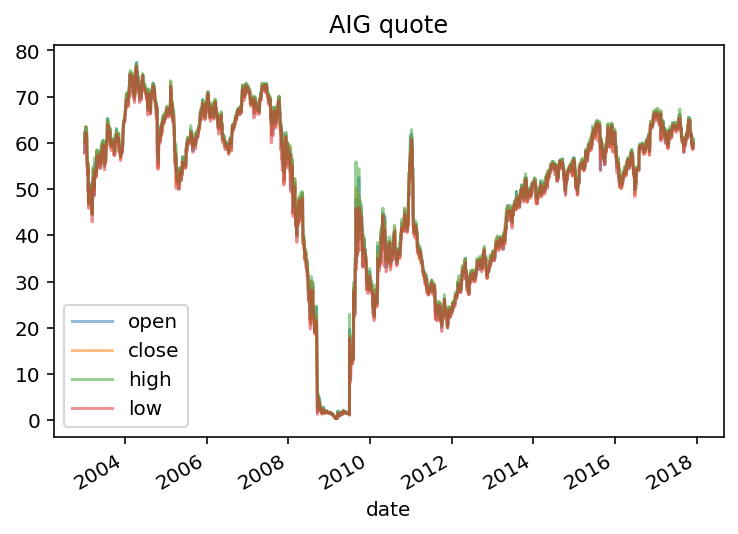

In [13]:
aig_data[['open','close','high','low']].plot(alpha=0.5, title='AIG quote')


Two very steep changes in a couple of days. Are they caused by splits? Before trying to answer, let us make a 'zoom' of this area

<AxesSubplot:title={'center':'AIG quote (2008 and 2009)'}, xlabel='date'>

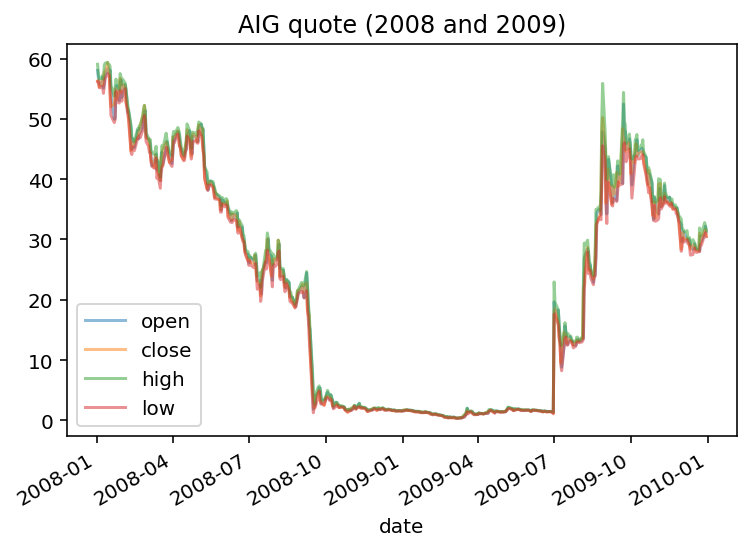

In [14]:
aux_data = aig_data[(aig_data.index<'20091231') & (aig_data.index>'20080101') ] 
aux_data[['open','close','high','low']].plot(alpha=0.5, title='AIG quote (2008 and 2009)')


The decreasing change is more progressive, although there is a strong decrease around August 2008. At the time the actual effects of the subprime crisis on AIG were being revealed. 

The upward tendency occurs quite quickly starting from 2009-07. Now, leat us look at the splits

<AxesSubplot:title={'center':'AIG split ratio'}, xlabel='date'>

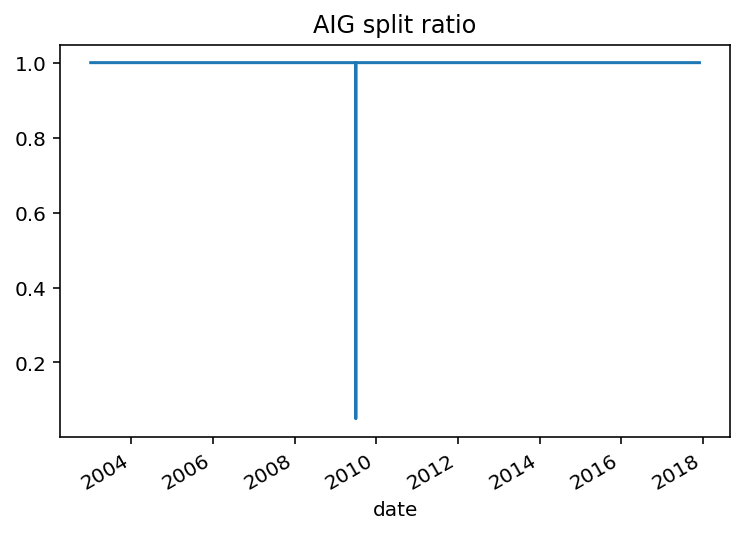

In [15]:
aig_data['split_ratio'].plot(title='AIG split ratio')

In [16]:
aig_data['split_ratio'].idxmin()

Timestamp('2009-07-01 00:00:00')

In [17]:
aig_data['split_ratio'].min()

0.05

This correspons to the upward trend before. Unlike Apple, this share rather tah  aplitting actually merged some stocks!

We can now check the adjusted prices

<AxesSubplot:title={'center':'AIG adjusted prices'}, xlabel='date'>

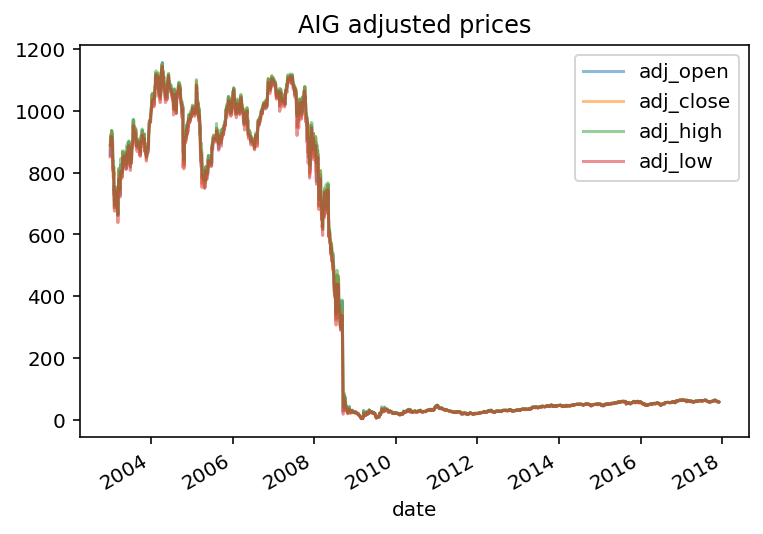

In [18]:
aig_data[['adj_open','adj_close','adj_high','adj_low']].plot(alpha=0.5, title='AIG adjusted prices')

<AxesSubplot:title={'center':'AIG adjusted prices (2009 onwards)'}, xlabel='date'>

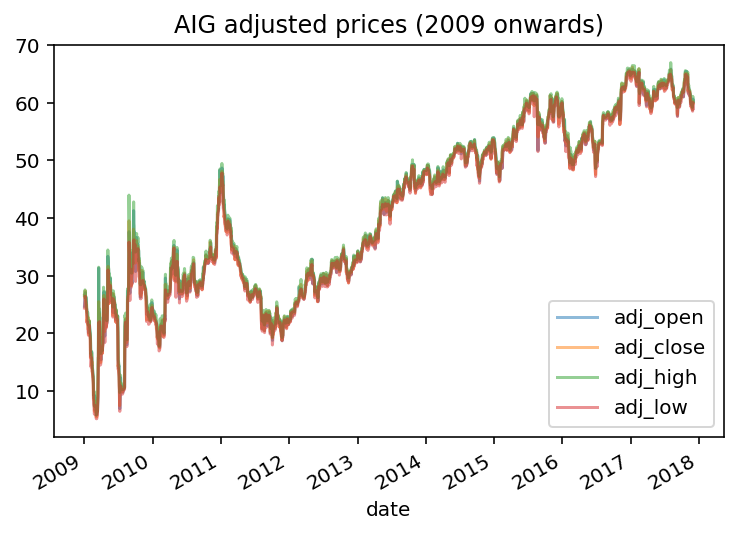

In [19]:
aux_data = aig_data[(aig_data.index>'2009-01-01')] 
aux_data[['adj_open','adj_close','adj_high','adj_low']].plot(alpha=0.5, title='AIG adjusted prices (2009 onwards)')

The picture is grim. The stock lost an important part of its value and has ever since recovered some ground (albeit negligible with respect to initial losses).

Finally, we look at the traded adjusted volume

<AxesSubplot:xlabel='date'>

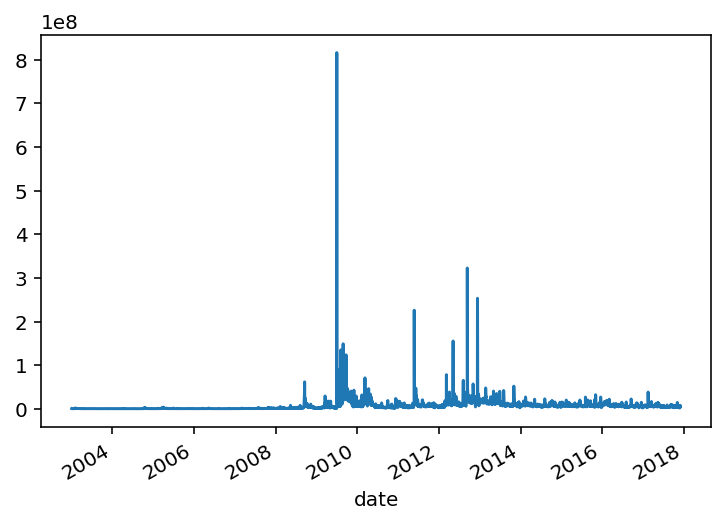

In [20]:
aig_data['adj_volume'].plot()

In [21]:
aig_data['adj_volume'].argmax()

1635

In [22]:
aig_data['adj_volume'].max()

816446000.0

The volume has a very large peak precisely on the date of the split. It is not unlikely, but if this number were relevant to us, we would need to find out what happened that day. 

## Risk measure estimation : one day

In the following, we will implement and compare the closed form and historical simualtion approaches for the estimation of value at risk of the changes in the AIG adjusted close price. 

To simplify the exercise, we suppose that we want to estimate a one day value at risk. Moreover,we SUPPOSE that we are making the calculations on the 01/01/2008. Therefore, we will only consider the data base before this date.


Let us find another database that only takes these dates into consideration

In [23]:
sub_aig_data = aig_data[aig_data.index< '2008-01-01']
sub_aig_data = sub_aig_data['adj_close']
sub_aig_data.tail()

date
2007-12-24    925.172558
2007-12-26    918.077203
2007-12-27    894.785930
2007-12-28    893.706202
2007-12-31    899.259088
Name: adj_close, dtype: float64

### Closed form

Remember that the key point to use a close form approximation is to find a suitable risk mapping where the risk factors are Gaussian.

Our candidate is to define as risk factor
$$F_{t+1}:= \log(S_{t+1})-\log(S_t)$$

Let us examine if
1. This factor seems stationary
1. This factor seems Gaussian


#### Stationarity

In [24]:
log_returns = np.log(sub_aig_data).diff()
log_returns.head()

date
2003-01-02         NaN
2003-01-03   -0.002990
2003-01-06    0.033047
2003-01-07   -0.019664
2003-01-08   -0.012552
Name: adj_close, dtype: float64

In [25]:
log_returns.drop(log_returns.index[0],inplace=True)
log_returns.head()

date
2003-01-03   -0.002990
2003-01-06    0.033047
2003-01-07   -0.019664
2003-01-08   -0.012552
2003-01-09    0.036391
Name: adj_close, dtype: float64

<AxesSubplot:xlabel='date'>

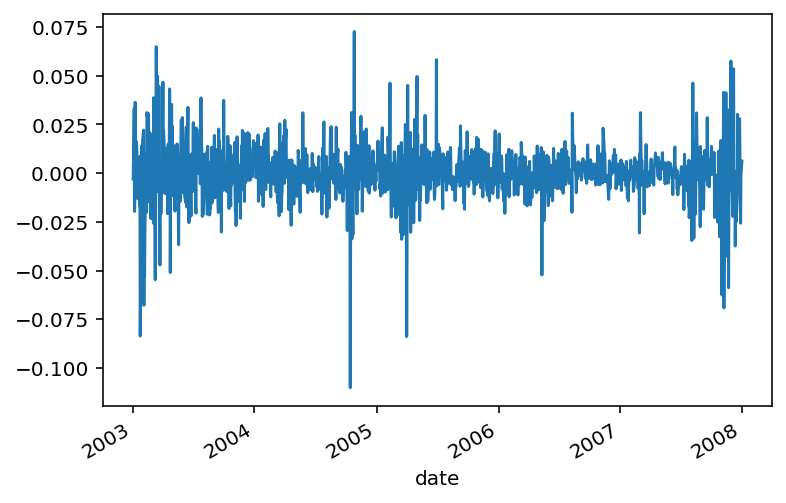

In [26]:
log_returns.plot()

Let us also look at variances and covariances within one month periods. 

<AxesSubplot:title={'center':'Mean for subsamples of size 60 days'}, xlabel='date'>

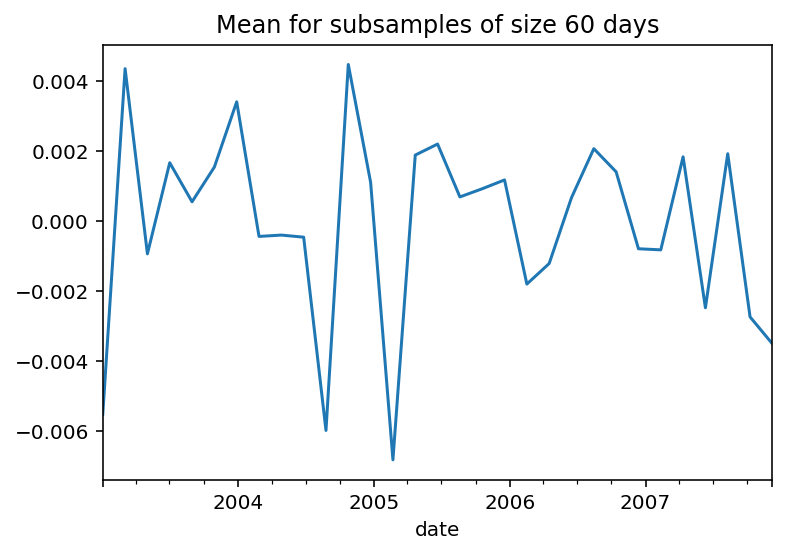

In [27]:
log_returns.resample('60d').mean().plot(title='Mean for subsamples of size 60 days')

The mean of each subsample seems to be rather random around a costant mean value. This is not agians stationarity.
Let us test the standard deviation as well

<AxesSubplot:title={'center':'Std. Dev for subsamples of size 60 days'}, xlabel='date'>

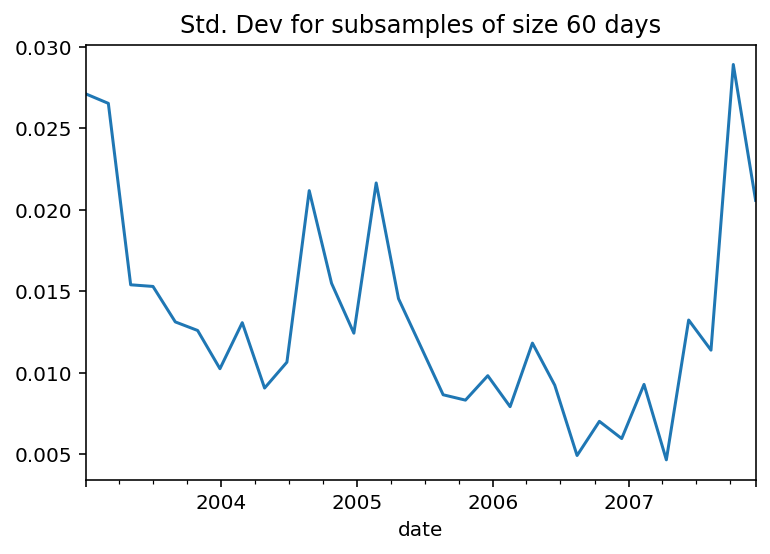

In [28]:
log_returns.resample('60d').std().plot(title='Std. Dev for subsamples of size 60 days')

This plot seems slighly less random, but still reasonable.

Text(0, 0.5, 'autocorrelation')

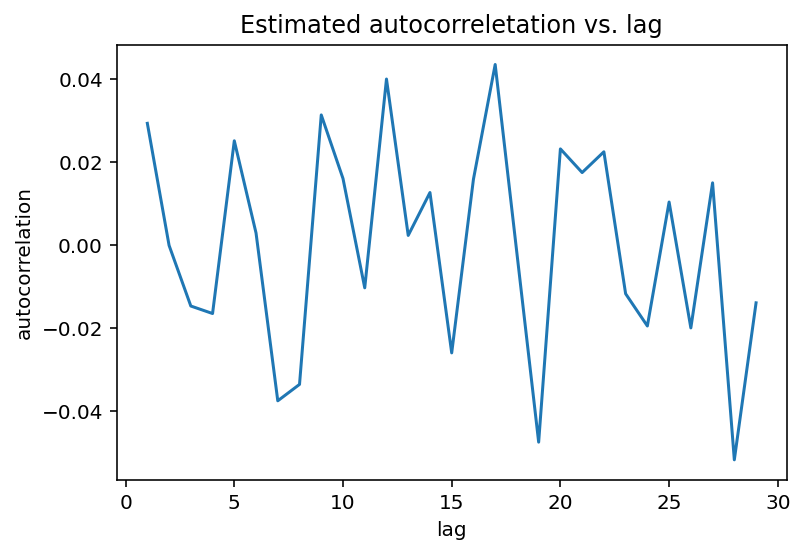

In [29]:
autocorr_vect = [log_returns.autocorr(lag=_) for _ in range(1,30)]
plt.plot(range(1,30),autocorr_vect)
plt.title('Estimated autocorreletation vs. lag')
plt.xlabel('lag')
plt.ylabel('autocorrelation')

Very small estimated autocorrelation. Finally, let us check the augmented Dickey-Fueller test.

In [30]:
adfuller(log_returns)[1]

0.0

All in all, we cannot seem to have enough evidence agains stationnarity. How about normality?

#### Normality

Text(0.5, 1.0, 'Histogram of log-retunrs and Gaussian with the same mean and variance')

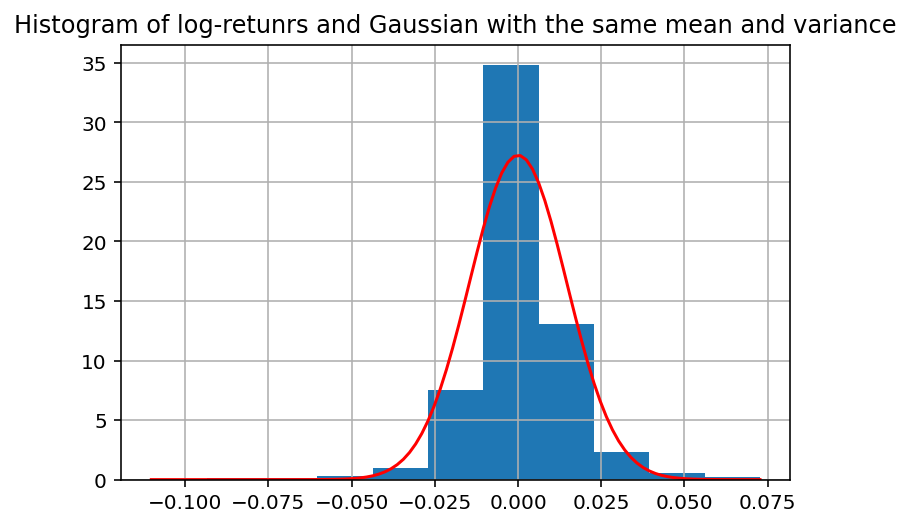

In [31]:
numbins = int(1+ np.log2(log_returns.count())) 
log_returns.hist(bins = numbins, density=True)

mu_log = np.mean(log_returns)
sigma_log = np.std(log_returns)
x_ticks = np.linspace(min(log_returns), max(log_returns),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r')
plt.title('Histogram of log-retunrs and Gaussian with the same mean and variance')


Visually, the fit is not clear, although the divergences are not extraordiary. Let us look at another tool to check this

((array([-3.2629588 , -3.00266919, -2.857728  , ...,  2.857728  ,
          3.00266919,  3.2629588 ]),
  array([-0.11019879, -0.08391532, -0.08365994, ...,  0.05826549,
          0.0649579 ,  0.07269368])),
 (0.014012626662414988, 1.0022667870343473e-05, 0.9547558083408232))

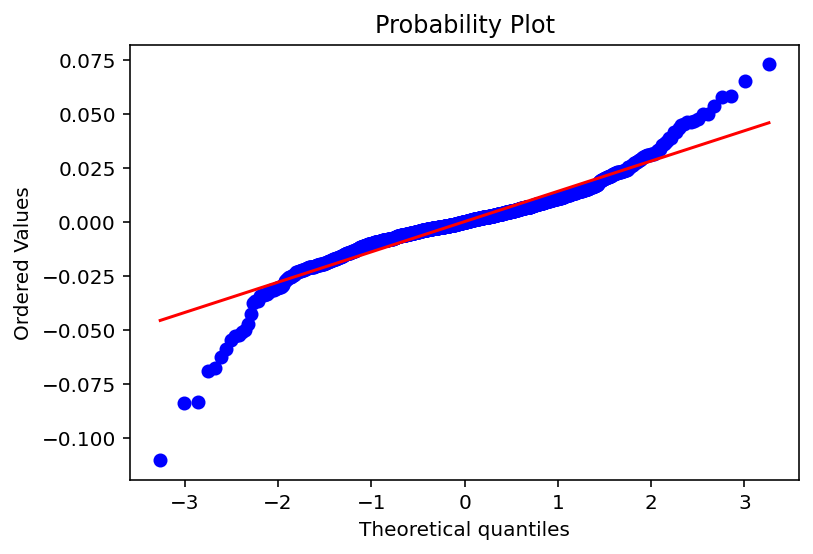

In [32]:
stats.probplot(log_returns,dist='norm', plot=plt)

In [33]:
stats.normaltest(log_returns) 


NormaltestResult(statistic=237.92592871947468, pvalue=2.162922844964407e-52)

So the p-value is very small. Yet another indication against normality.

This means we cannot assume full normality of the whole series.


Despite the above, for the sake of comparison, let us see what the risk measures would be if assuming normality. Recall from the lecture that the delta approximation gives

$$ \Delta V_{k+1} \approx V_k F_{k+1} $$

and so the formulas for the risk measures are

$${\rm VaR}(\Delta V_{k+1}) = V_k\sigma \Phi(\alpha) - V_k \mu_k  $$
$${\rm ES}(\Delta V_{k+1}) = V_k\sigma \frac{\phi(\Phi(\alpha))}{1-\alpha} - V_k \mu_k  $$

In [34]:
alpha_var=0.99
alpha_es=0.975
VaR_CF =sub_aig_data.iloc[-1]*( -mu_log + sigma_log*stats.norm.ppf(alpha_var))
ES_CF =sub_aig_data.iloc[-1]*( -mu_log + sigma_log*stats.norm.pdf(stats.norm.ppf(alpha_es))/(1-alpha_es))
print('CLOSED FORM: ')
print('Each unit of stock of AIG with closing date ', sub_aig_data.index[-1], 
      ' and closing (adjusted) value of ', sub_aig_data.iloc[-1],
      ' has for one day a VaR at level ', alpha_var, ' of ', VaR_CF,
      ' and a one day ES at level ', alpha_es, ' of ', ES_CF,'.')

CLOSED FORM: 
Each unit of stock of AIG with closing date  2007-12-31 00:00:00  and closing (adjusted) value of  899.2590883868303  has for one day a VaR at level  0.99  of  30.624608057569294  and a one day ES at level  0.975  of  30.775447760353096 .


### Historical simulation: one day

We have already tested stationarity, we can calculate directly the historical simulation of one day of value at risk and expected shortfall at the assumed levels. 

To do that, we first calculate what would be the P&L between 'today' and 'tomorrow' (that is from 2007/12/31 to 2008/01/01) using as possible outcomes the past values of the log-returns. The formula in this case is simply

$$ \Delta V_{k+1}^{i} = V_k*(\exp(F_{k-i})-1) $$


In [35]:
hs_prices = sub_aig_data.iloc[-1] * (np.exp(log_returns)-1)

In [36]:
hs_prices.head()

date
2003-01-03    -2.684355
2003-01-06    30.214627
2003-01-07   -17.510517
2003-01-08   -11.216755
2003-01-09    33.328033
Name: adj_close, dtype: float64

Let us look quickly at the histogram of possible changes

<AxesSubplot:>

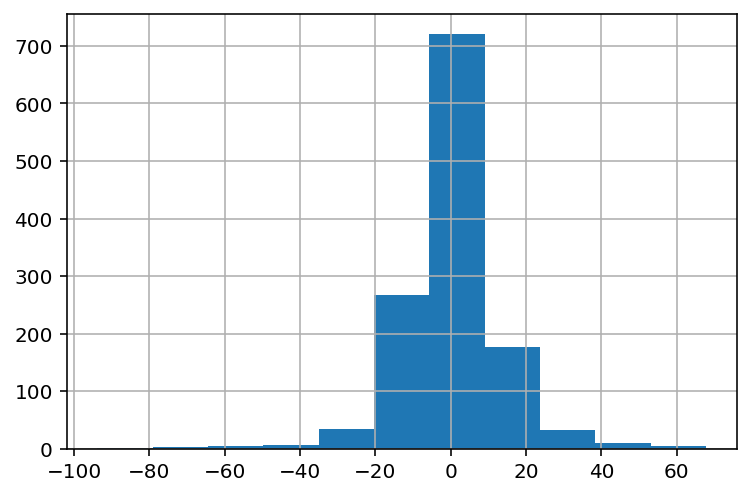

In [37]:
hs_prices.hist(bins=numbins)

Now we calculate the estimators for the position in value at risk and expected shortfall. 
We first order the samples and choose one of the estimators we saw in class. I will simply take the '+' value at risk and its corresponding expected shortfall. **Please remember that observations start at zero**

In [38]:
hs_prices.sort_values(inplace=True)
hs_prices.head()

date
2004-10-14   -93.832229
2005-04-01   -72.382161
2003-01-24   -72.170966
2007-11-07   -60.143839
2003-02-04   -58.997117
Name: adj_close, dtype: float64

In [39]:
ind_var = int( hs_prices.size * (1-alpha_var))-1
ind_es = int( hs_prices.size * (1-alpha_es))-1
print(ind_var,ind_es)

11 30


In [40]:
VaR_HS = -1*hs_prices.iloc[ind_var]
ES_HS = -1*hs_prices.iloc[:ind_es+1].mean()

print('Historical Simulation: ')
print('Each unit of stock of AIG with closing date ', sub_aig_data.index[-1], 
      ' and closing (adjusted) value of ', sub_aig_data.iloc[-1],
      ' has for one day a VaR at level ', alpha_var, ' of ', VaR_HS,
      ' and a one day ES at level ', alpha_es, ' of ', ES_HS,'.')


Historical Simulation: 
Each unit of stock of AIG with closing date  2007-12-31 00:00:00  and closing (adjusted) value of  899.2590883868303  has for one day a VaR at level  0.99  of  44.16004451899178  and a one day ES at level  0.975  of  40.86661378600221 .


Clearly these values represent a significative increase of 44% and 32.7% !

In [41]:
print('Increase (in %) w.r.t. close form: VaR:',100*(VaR_HS/VaR_CF-1) , 'ES:',100*(ES_HS/ES_CF-1))

Increase (in %) w.r.t. close form: VaR: 44.197909197655896 ES: 32.78966435916231
